<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We're going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you'll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

<h3><font color=steelblue>Pollution dataset </font></h3>

<h4><font color=mediumvioletred>Setup</font></h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
plt.style.use("ggplot")

<h4><font color=mediumvioletred>Read CSV files</font></h4>

In [2]:
df_ap_np = pd.read_csv('data/air_pollution.csv')
df_ap = pd.read_csv("data/air_pollution.csv", parse_dates=["date"])
df_ap_per_date_per_postalcode = df_ap.groupby([pd.Grouper(freq='D', key='date'),
                     'PC4']).mean()

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..)</font></h4>

In [3]:
df_ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76824 entries, 0 to 76823
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    76824 non-null  datetime64[ns]
 1   PC4     76824 non-null  int64         
 2   pm10    76824 non-null  float64       
 3   pm2.5   76824 non-null  float64       
 4   no2     76824 non-null  float64       
 5   no      76824 non-null  float64       
 6   so2     76824 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.1 MB


<h4><font color=mediumvioletred>Get the generate descriptive statistics of the columns</font></h4>

In [4]:
df_ap.describe()

,PC4,pm10,pm2.5,no2,no,so2
count,76824.000000,76824.000000,76824.000000,76824.000000,76824.000000,76824.000000
mean,5633.818182,19.300461,19.306449,25.810896,14.578421,3.419556
std,15.168756,12.790363,19.325968,13.715641,12.749047,3.060791
min,5611.000000,0.491714,0.419603,1.665652,0.000398,0.000000
25%,5622.000000,9.789488,5.986320,14.671372,4.785573,1.330161
50%,5631.000000,16.246310,12.186803,23.211536,12.002913,2.583675
75%,5646.000000,26.378854,26.603072,35.263642,22.173757,4.383727
max,5658.000000,89.593300,144.709400,79.853535,145.954814,26.323172


<h4><font color=mediumvioletred>Testing for Normality</font></h4>

Skewness per column:
PC4      0.133642
pm10     1.312018
pm2.5    2.101590
no2      0.621710
no       1.845079
so2      2.078176
dtype: float64


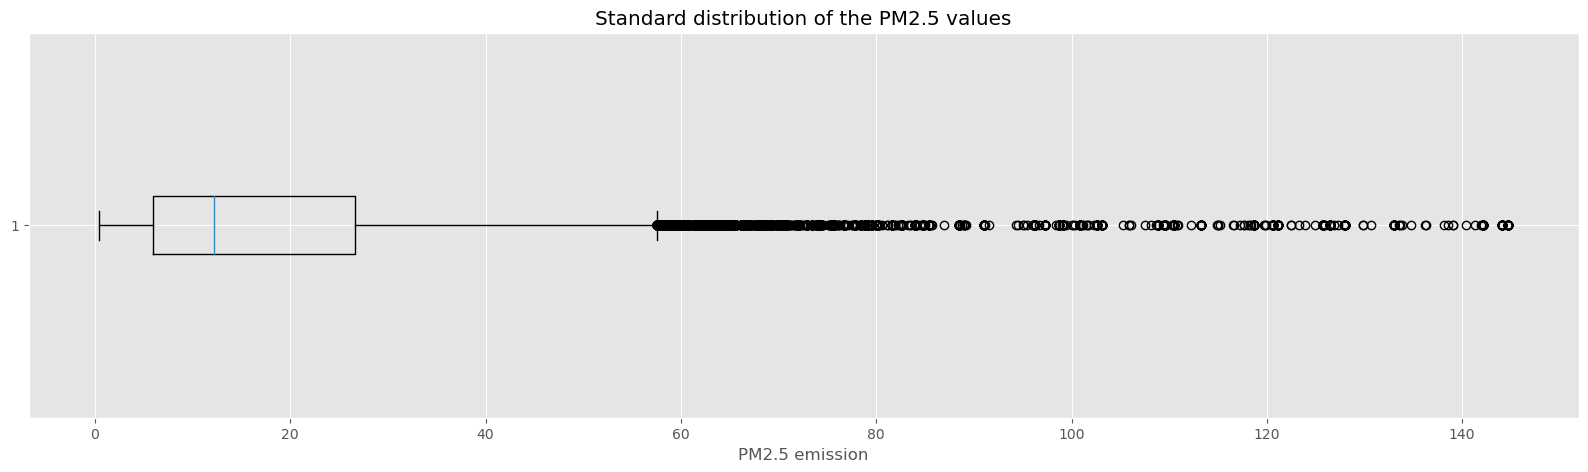

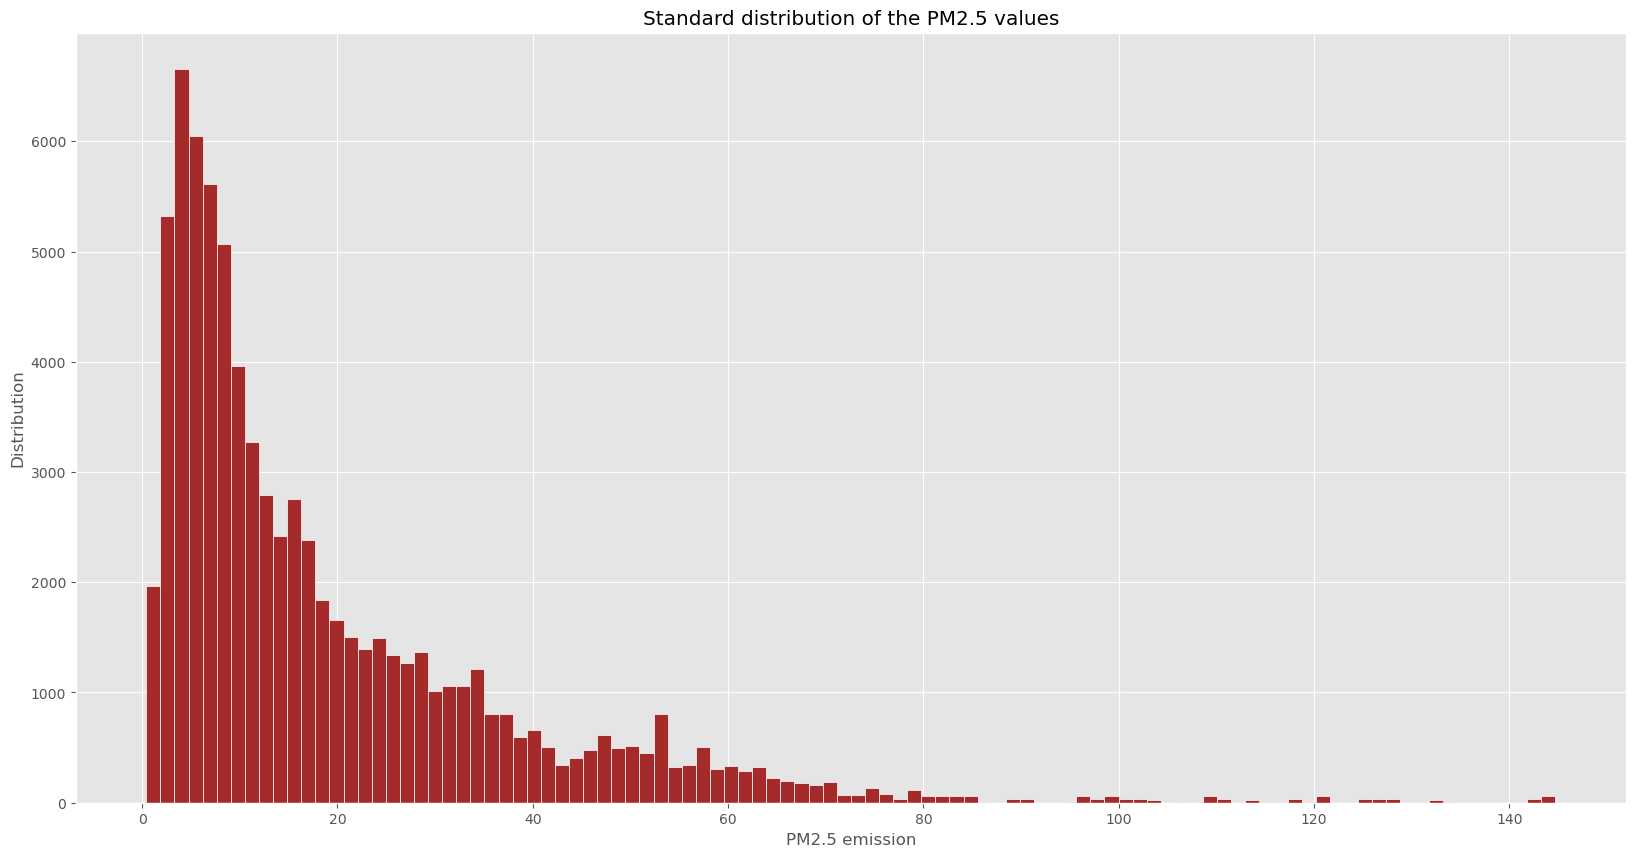

In [5]:
print("Skewness per column:")
print(df_ap.skew(numeric_only=True))

plt.figure(figsize=(20,5))
plt.boxplot( df_ap['pm2.5'], vert=False)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.show()

plt.figure(figsize=(20,10))
plt.hist(df_ap['pm2.5'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.ylabel("Distribution")
plt.show()

Most skewed data in the dataset is the PM2.5 data. <br>
The distribution of the PM2.5 data has a short head and a long tail.<br>
The tail seems to be peaking, possible anomalies.

<h4><font color=mediumvioletred>Correlations in the dataset - Correlation matrix</font></h4>

In [6]:
df_ap.corr(numeric_only=True)

,PC4,pm10,pm2.5,no2,no,so2
PC4,1.000000,-0.022215,-0.015463,-0.032789,-0.024208,-0.000279
pm10,-0.022215,1.000000,0.842424,0.443763,0.419273,0.354938
pm2.5,-0.015463,0.842424,1.000000,0.252095,0.178604,0.162552
no2,-0.032789,0.443763,0.252095,1.000000,0.674611,0.362617
no,-0.024208,0.419273,0.178604,0.674611,1.000000,0.309740
so2,-0.000279,0.354938,0.162552,0.362617,0.309740,1.000000


PM2.5 column is deeply correlated with the PM10 column.

<h4><font color=mediumvioletred>Correlations in the dataset - Testing different correlation functions on PM2.5 column</font></h4>

In [7]:
print('Pearson: ' + str(df_ap['pm2.5'].corr(df_ap['pm10'], method='pearson')))
print('Spearman: ' + str(df_ap['pm2.5'].corr(df_ap['pm10'], method='spearman')))


Pearson: 0.8424240709438268
Spearman: 0.8868444860412877


The two column excibit a high relationship both linearly and monotonically.

<h4><font color=mediumvioletred>Correlations in the dataset - Plotting the correlation between the PM10 and the PM2.5 columns</font></h4>

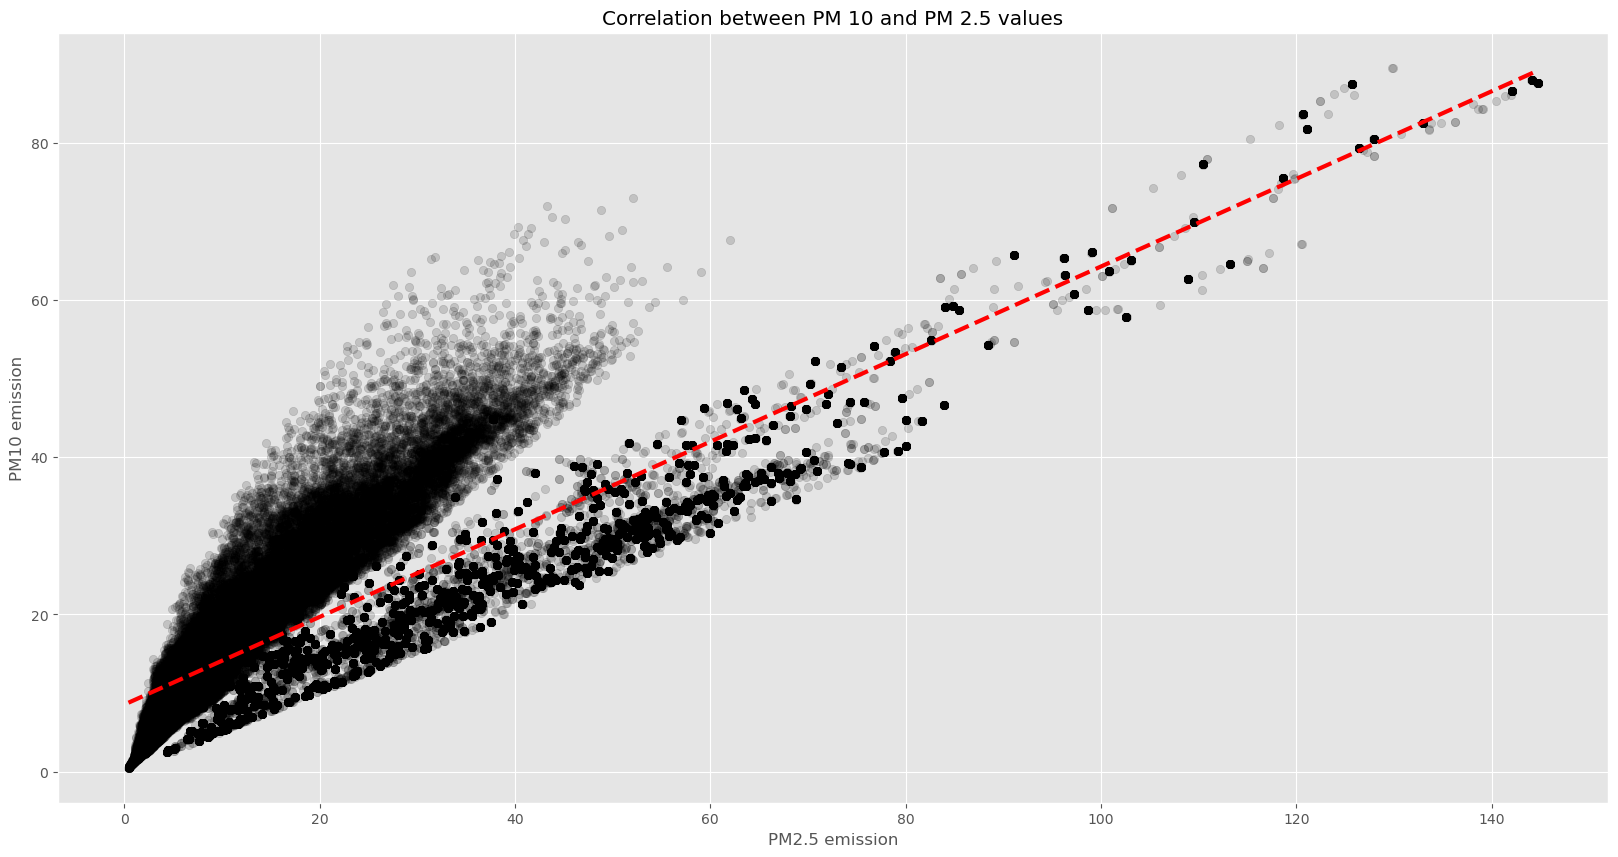

In [8]:
plt.figure(figsize=(20,10))
plt.scatter(df_ap["pm2.5"], df_ap["pm10"], alpha=.15, color='black')
plt.plot(np.unique(df_ap["pm2.5"]), np.poly1d(np.polyfit(df_ap["pm2.5"], df_ap["pm10"], 1))
         (np.unique(df_ap["pm2.5"])), color='red', linewidth=3, linestyle='dashed')
plt.xlabel('PM2.5 emission')
plt.ylabel('PM10 emission')
plt.title("Correlation between PM 10 and PM 2.5 values")
plt.show()

<h4><font color=mediumvioletred>PM2.5 values - Daily average(mean) </font></h4>

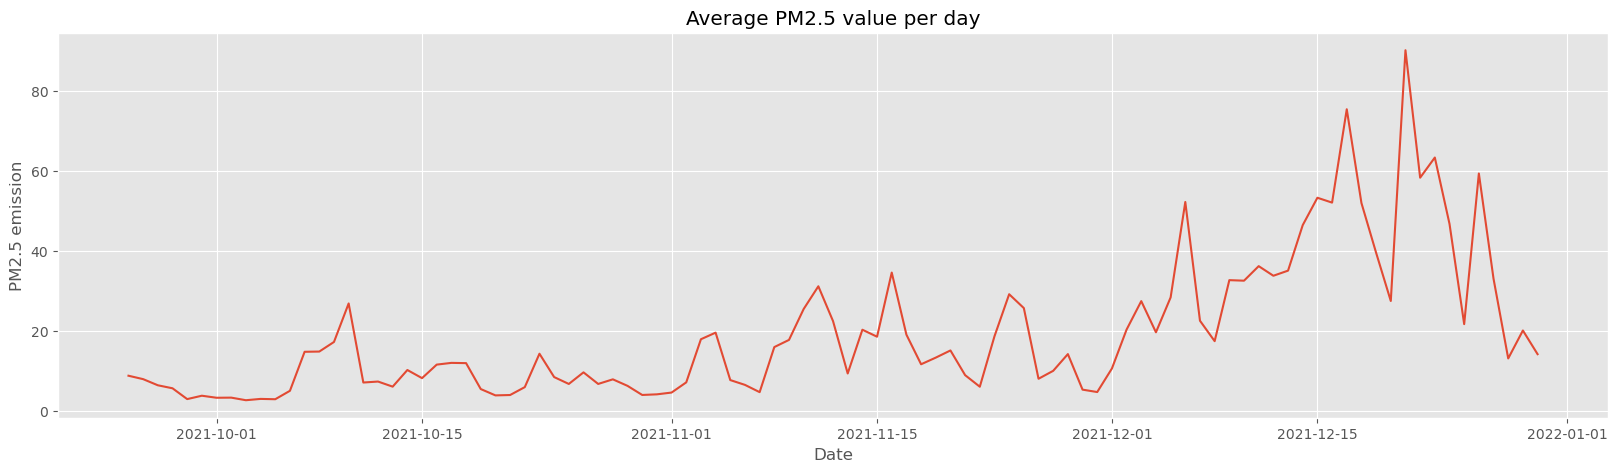

In [9]:
df_ap_day_mean = df_ap.groupby(pd.Grouper(freq='D', key='date')).mean()
plt.figure(figsize=(20,5))
plt.title("Average PM2.5 value per day")
plt.plot(df_ap_day_mean['pm2.5'])
plt.xlabel("Date")
plt.ylabel("PM2.5 emission")
plt.show()

The daily PM2.5 pollution is very high in the month of December

<h4><font color=mediumvioletred> Worst mean total pollution in different postal code areas</font></h4>

In [10]:
df_ap_sp = df_ap.groupby(['PC4']).mean(numeric_only=True)
print('Most populated areas with the pollution type:')
df_ap_sp = df_ap_sp.drop_duplicates()
df_ap_sp.reset_index().style.highlight_max(color = 'orange')

Most populated areas with the pollution type:


,PC4,pm10,pm2.5,no2,no,so2
0,5611,19.984079,19.960272,26.572523,15.087846,3.490208
1,5612,19.963204,19.884173,26.624472,15.121834,3.475344
2,5613,19.471481,19.590238,26.040624,14.739848,3.420596
3,5614,19.324781,19.479003,25.688555,14.509505,3.404681
4,5615,19.718299,19.725237,25.956133,14.684570,3.465811
5,5616,20.062076,20.000029,26.235977,14.867659,3.507084
6,5617,20.190379,20.063174,26.374419,14.958236,3.504149
7,5621,19.835366,19.854896,26.110725,14.785713,3.432458
8,5622,19.865506,19.830804,26.289081,14.902403,3.430030
9,5623,20.074333,19.975982,26.695390,15.168232,3.453108


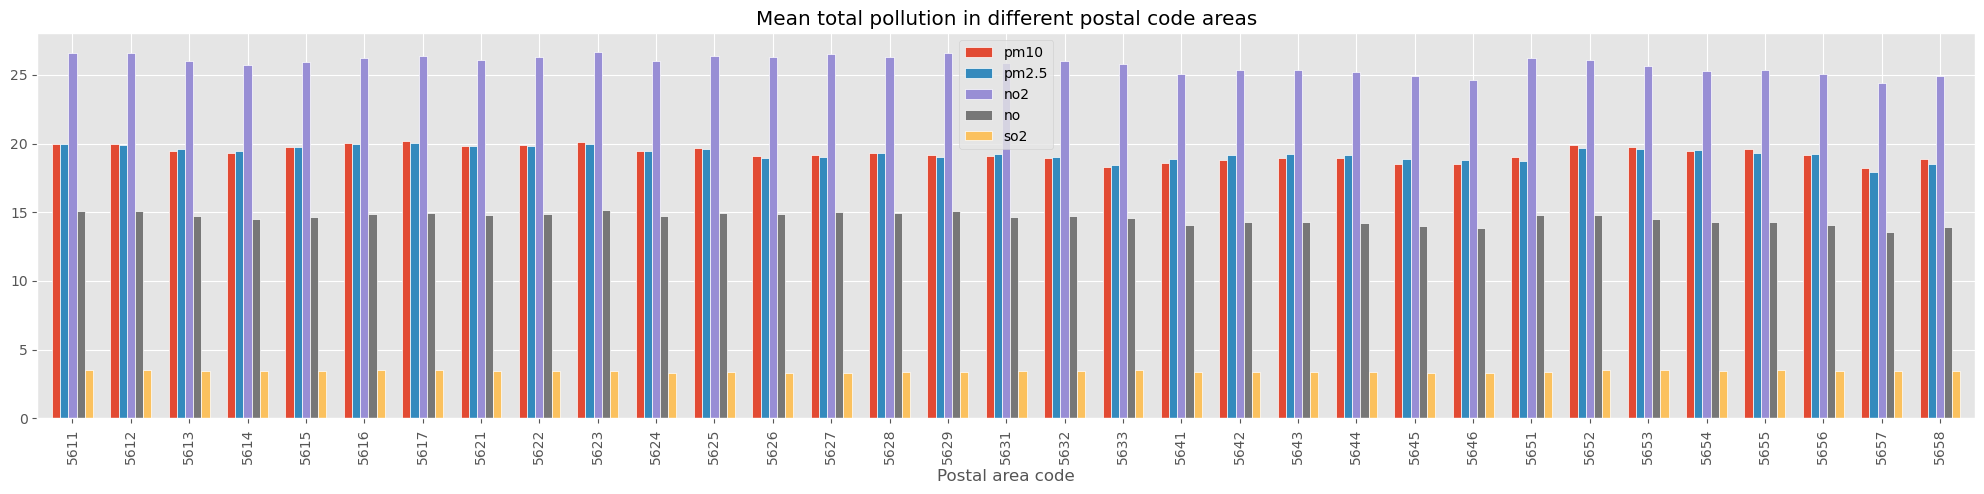

In [29]:
plot = df_ap_sp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Mean total pollution in different postal code areas")

<h4><font color=mediumvioletred> Most peak pollution in different postal code areas</font></h4>

In [22]:
df_ap_mp = df_ap.groupby(['PC4']).max(numeric_only=True)
print('Most polluted areas per pollution type:')
#Only grabs the first value, or none
print(df_ap_mp.idxmax())
df_ap_mp = df_ap_mp.drop_duplicates()
df_ap_mp.reset_index().style.highlight_max(color = 'orange')

Most polluted areas per pollution type:
pm10     5658
pm2.5    5611
no2      5658
no       5658
so2      5625
dtype: int64


,PC4,pm10,pm2.5,no2,no,so2
0,5611,88.080540,144.709400,71.381888,121.946628,23.344864
1,5612,88.080540,144.709400,71.274923,121.946628,25.220871
2,5613,88.080530,144.709400,69.206424,121.946628,23.386072
3,5614,88.080530,144.709400,68.357741,121.946628,20.949102
4,5615,88.080530,144.709400,71.718876,121.946628,21.319842
5,5616,88.080530,144.709400,75.743100,121.946628,24.085637
6,5617,88.080540,144.709400,76.095894,121.946628,25.071658
7,5621,88.080540,144.709400,73.775033,121.946628,26.241260
8,5622,88.080540,144.709400,72.820876,121.946628,26.130241
9,5623,88.080530,144.709400,71.342982,121.946628,26.261284


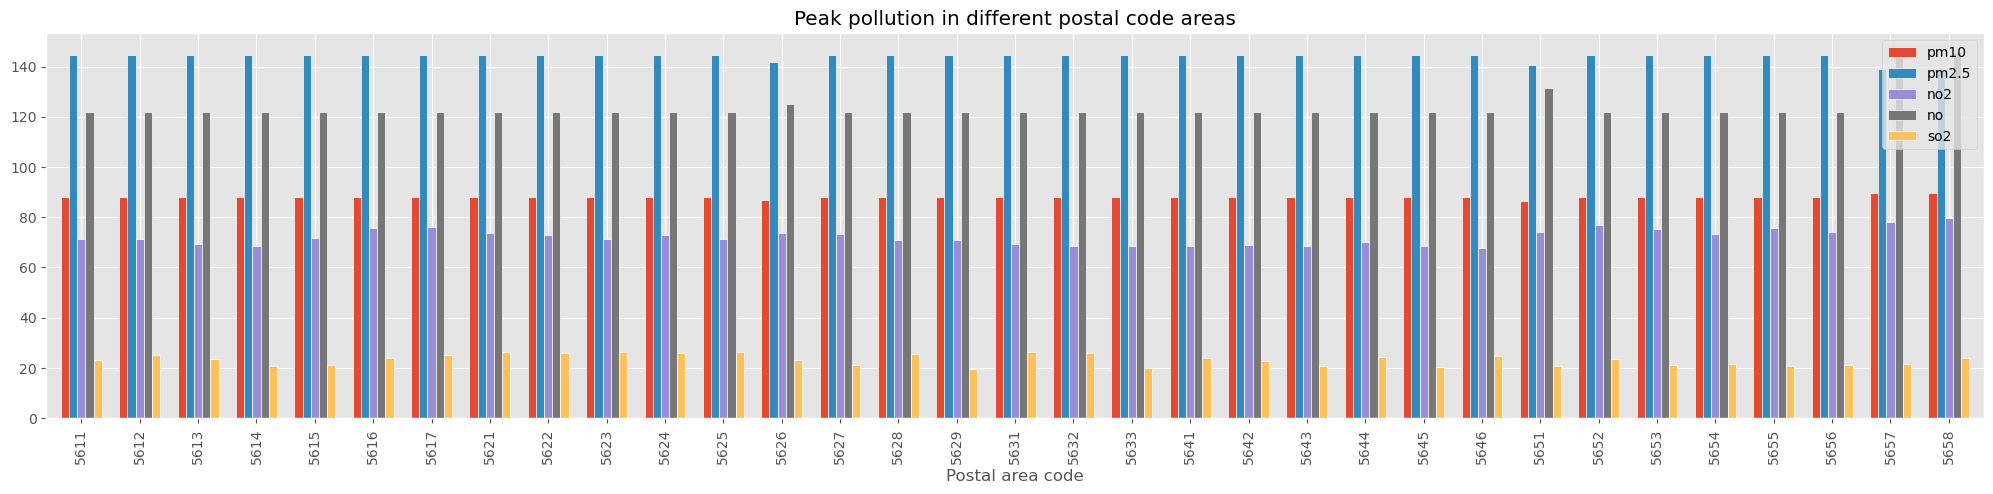

In [30]:
plot = df_ap_mp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Peak pollution in different postal code areas")

There are several instances of the PM2.5 pollution with the value of 144.709400. <br>
The PM2.5 sensor is probably peaking. 

<h4><font color=mediumvioletred> Least pollution in different postal code areas</font></h4>

In [14]:
df_ap_lp = df_ap.groupby(['PC4']).min(numeric_only=True)

print('Least polluted areas per pollution type:')
#Only grabs the first value, or none
print(df_ap_lp.idxmin())

df_ap_lp = df_ap_lp.drop_duplicates()
df_ap_lp.reset_index().style.highlight_min(color = 'lightgreen')

Least polluted areas per pollution type:
pm10     5644
pm2.5    5644
no2      5646
no       5611
so2      5658
dtype: int64


,PC4,pm10,pm2.5,no2,no,so2
0,5611,0.530789,0.451635,2.392360,0.000398,0.000000
1,5612,0.578179,0.473515,2.544250,0.000398,0.000000
2,5613,0.520031,0.439185,2.219685,0.000398,0.000000
3,5614,0.498157,0.427967,1.988143,0.000398,0.000000
4,5615,0.501704,0.430377,2.091708,0.000398,0.000000
5,5616,0.700163,0.534429,2.404782,0.000398,0.000000
6,5617,0.814963,0.579557,2.532816,0.000398,0.000000
7,5621,0.876251,0.615081,2.593142,0.000398,0.000000
8,5622,0.777373,0.573218,2.641720,0.000398,0.000000
9,5623,0.626090,0.506606,2.755169,0.000398,0.000000


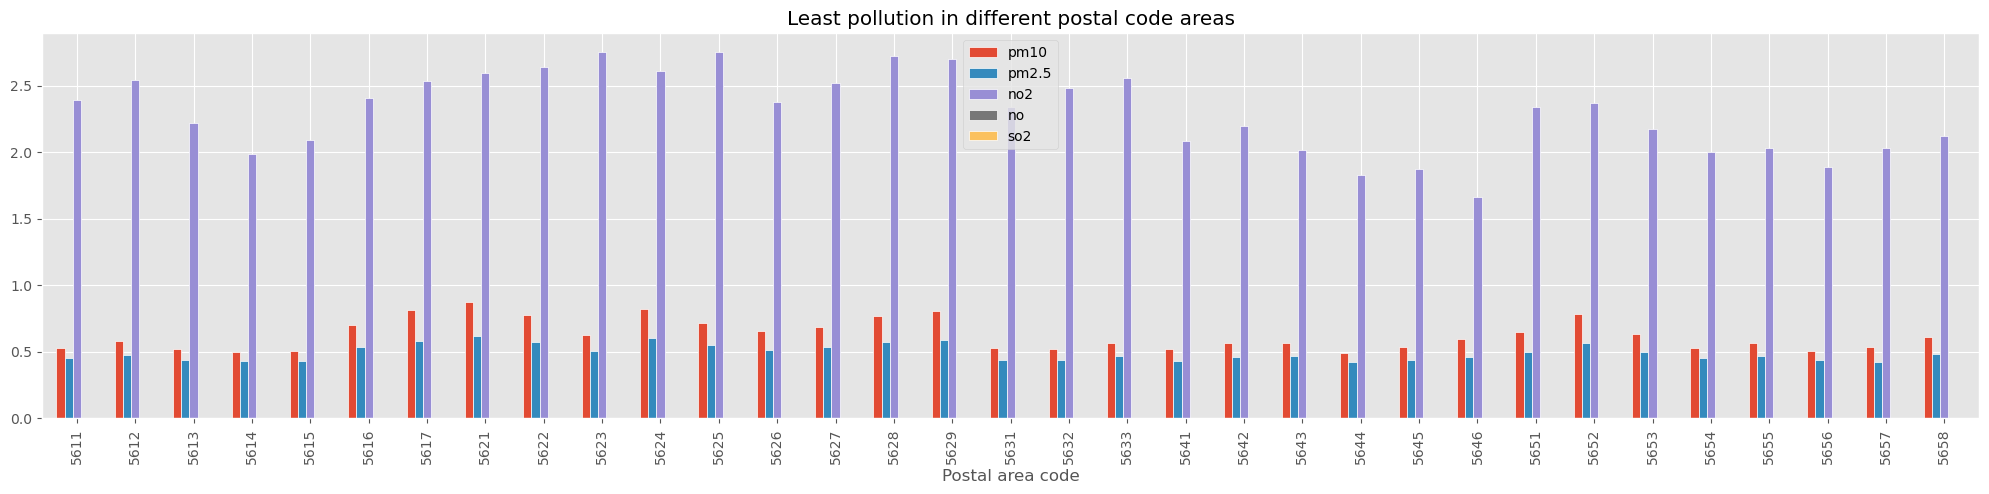

In [31]:
plot = df_ap_lp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Least pollution in different postal code areas")

The sulfur dioxide sensor is detecting nothing, sometimes.

<h4><font color=mediumvioletred>Comparing the most polluted postal code area(day mean) based on the pollution type with the same area on an average day</font></h4>

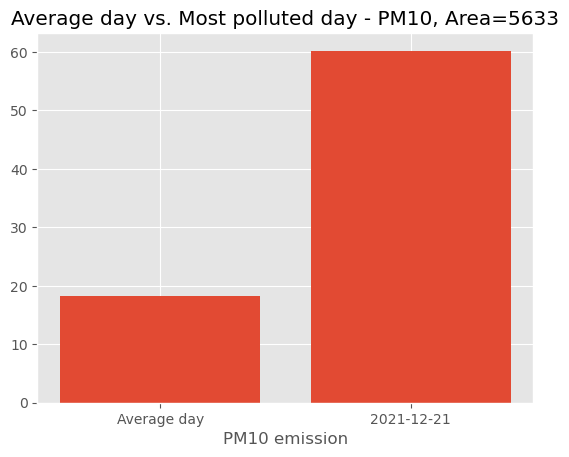

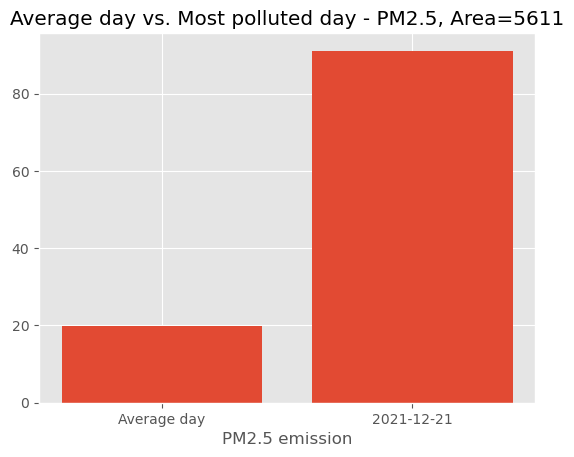

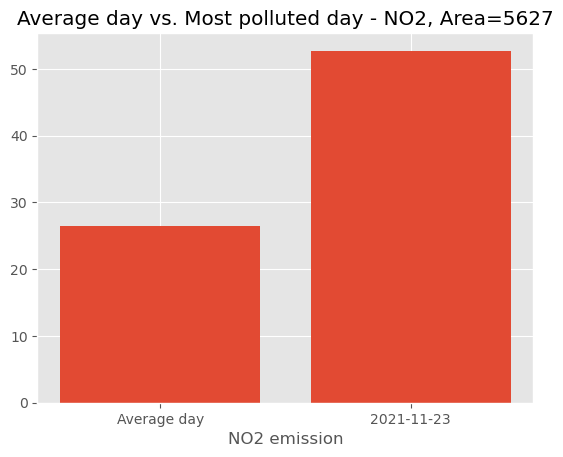

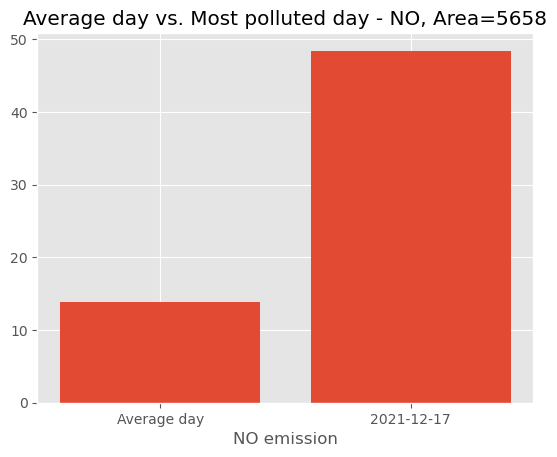

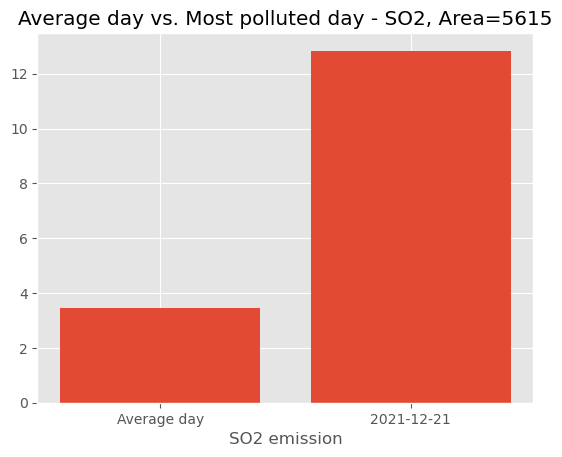

In [16]:
most_polluted_days = df_ap_per_date_per_postalcode.idxmax()

i = 0
for day in most_polluted_days:
    most_polluted_values = df_ap_per_date_per_postalcode.loc[(day[0] ,day[1]), :]
    all_for_postcode =  df_ap_per_date_per_postalcode.loc[(slice(None), day[1]), :]
    plt.bar(["Average day", str(day[0].date())], [all_for_postcode.mean()[most_polluted_days.index[i]], most_polluted_values.loc[most_polluted_days.index[i]]])
    plt.title("Average day vs. Most polluted day - " + str(most_polluted_days.index[i]).upper() + ", Area=" + str(day[1]) )
    plt.xlabel(str(most_polluted_days.index[i]).upper() + " emission")
    plt.show()
    i += 1

<h4><font color=mediumvioletred>Comparing the least polluted postal code area(day mean) based on the pollution type with the same area on an average day</font></h4>

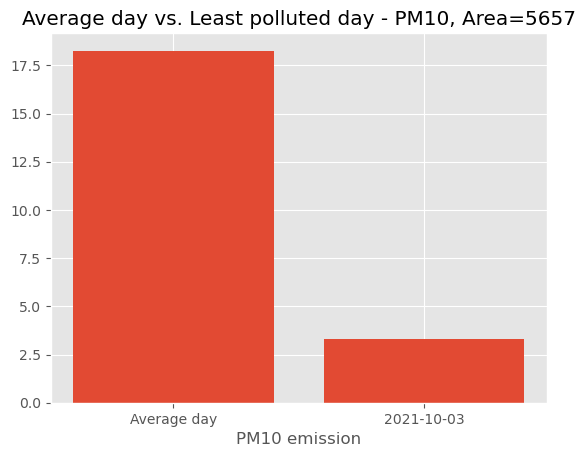

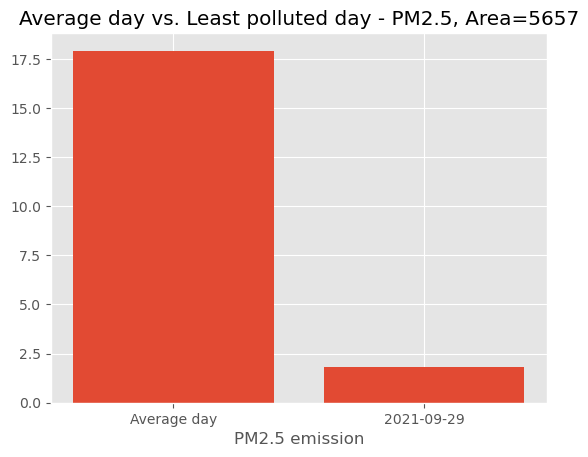

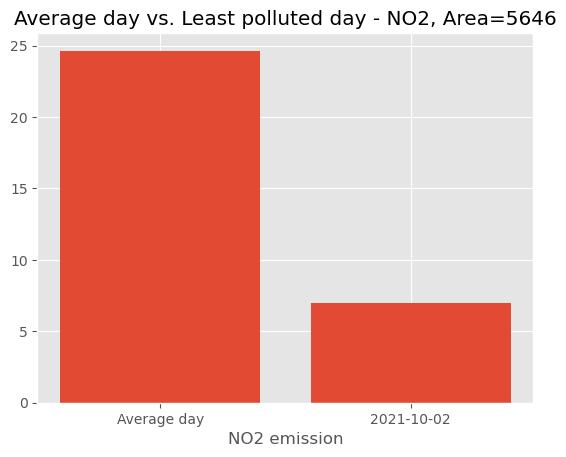

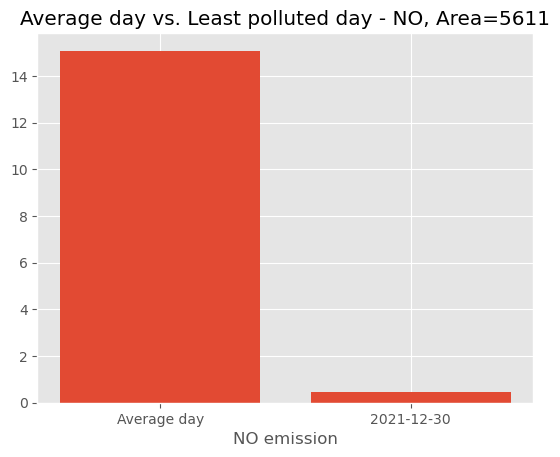

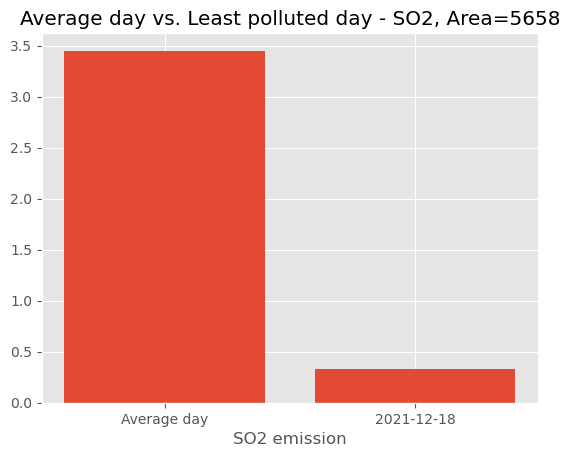

In [17]:
least_polluted_days = df_ap_per_date_per_postalcode.idxmin()

i = 0
for day in least_polluted_days:
    least_polluted_values = df_ap_per_date_per_postalcode.loc[(day[0] ,day[1]), :]
    all_for_postcode =  df_ap_per_date_per_postalcode.loc[(slice(None), day[1]), :]
    plt.bar(["Average day", str(day[0].date())], [all_for_postcode.mean()[least_polluted_days.index[i]], least_polluted_values.loc[least_polluted_days.index[i]]])
    plt.title("Average day vs. Least polluted day - " + str(least_polluted_days.index[i]).upper() + ", Area=" + str(day[1]) )
    plt.xlabel(str(least_polluted_days.index[i]).upper() + " emission")
    plt.show()
    i += 1

<h4><font color=mediumvioletred>A deeper look at the most polluted day in the most polluted area - PM2.5</font></h4>

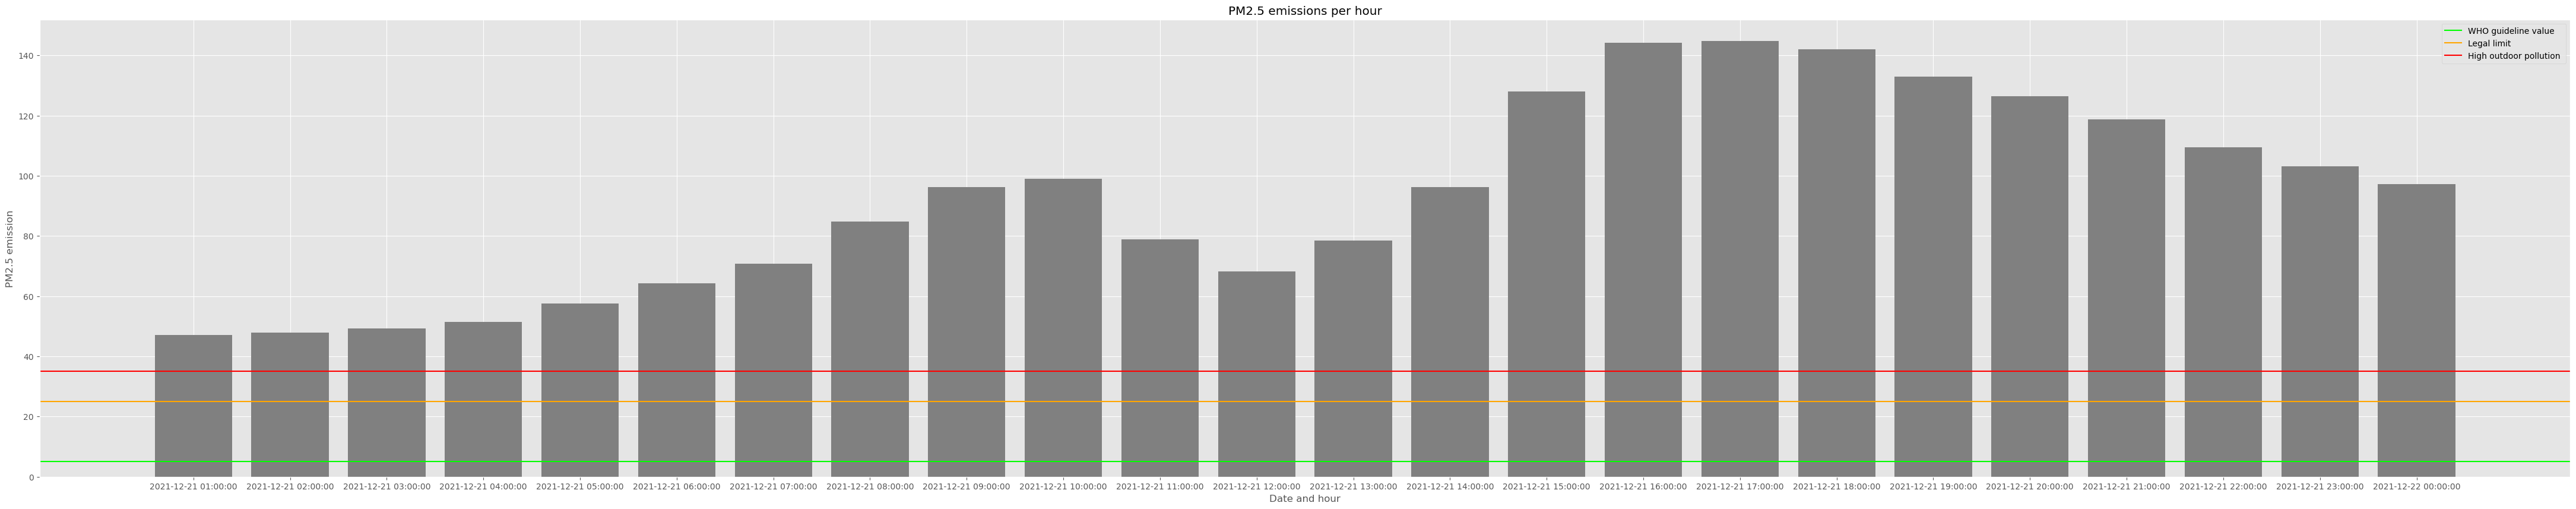

In [18]:
# DOUBLE CLICK ON THE GRAPH TO ZOOM IN #

most_polluted = df_ap_per_date_per_postalcode.idxmax()['pm2.5']
most_polluted_date = most_polluted[0].date() 
most_polluted_areacode = most_polluted[1]

START_DATE =  str(most_polluted_date + timedelta(days=-0))
END_DATE = str(most_polluted_date + timedelta(days=+1))

FIG_HEIGHT = 10
FIG_WIDTH = 55

mask = ((df_ap['date'] > START_DATE) & (df_ap['date'] <= END_DATE) & (df_ap['PC4'] <= most_polluted_areacode))
air_pollution = df_ap_np.loc[mask]

f = plt.figure()
f.set_figheight(FIG_HEIGHT)
f.set_figwidth(FIG_WIDTH)
plt.bar(air_pollution['date'], air_pollution['pm2.5'], color='gray')
plt.title("PM2.5 emissions per hour")
plt.xlabel("Date and hour")
plt.ylabel("PM2.5 emission")

healthy_level = [5]
legal_limit = [25]
unhealthy_level = [35]

plt.axhline(y = healthy_level, color = '#00FF00', linestyle = '-')
plt.axhline(y = legal_limit, color = '#FFA500', linestyle = '-')
plt.axhline(y = unhealthy_level, color = '#FF0000', linestyle = '-')
plt.legend(['WHO guideline value', 'Legal limit', 'High outdoor pollution '])
plt.show()

Sources for the limits: <br>
Safe Limit: https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health<br>
Legal limit: https://www.indoorairhygiene.org/pm2-5-explained/ <br>
Unhealthy limit: https://www.indoorairhygiene.org/pm2-5-explained/<br>

<h2><font color=slateblue> 5. Data Preparation </font></h2>

<h2><font color=slateblue> 6. Modelling </font></h2>